# ExploringTemporalData-Copy1

In [1]:
import pandas as pd
import numpy as np
import pprint
import random
import matplotlib.pyplot as plt

## Mathieu Guillame-Bert's Dataset

In [2]:
PATH = '/home/franticoreo/time_lstm/preprocess/data/dataset/part_1_1.event'

# SAMPLE
symbol_df = pd.read_table(PATH, header=None, names=['time', 'symbol']).sample(10)

print(symbol_df.head())
print(f"Shape of df: {symbol_df.shape}")
print(symbol_df['symbol'].nunique())

             time symbol
2774  35017.93735      b
4822  60056.67311      j
5872  72960.78149      j
6640  83587.97714      j
7227  91437.71157      b
Shape of df: (10, 2)
3


In [3]:
PATH = '/home/franticoreo/time_lstm/preprocess/data/dataset_refPred/part_1_1.pred'

symbol_df_pred_1_2 = pd.read_table(PATH, header=None, names=['start', 'end', 'symbol', 'probability'])

print(symbol_df_pred_1_2.head())
print(f"Shape of df: {symbol_df_pred_1_2.shape}")
print(symbol_df_pred_1_2['symbol'].nunique())

      start       end symbol  probability
0   19.8182   21.3200      a          0.6
1   97.4116   98.9134      a          0.6
2  181.5060  183.0080      a          0.6
3  273.3470  274.8490      a          0.6
4  293.0070  294.5090      a          0.6
Shape of df: (1097, 4)
1


## Generating My Own Data

In [4]:
body_constr = [0,20]
head_constr = [0,10]


def time_interval(body_constr): return tuple(np.random.uniform(body_constr)) 

def unique_body_symbols(n_bod_symbols):
    '''Creates a random unique list of symbols for the body 
    of pattern. A has been excluded from the list as it is reserved 
    for the head of the pattern.
        Args: 
            n_body_symbols: int
    '''
    symbols = ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'] # excluding symbol a
    # create a random list of unique symbols for the body (excluding head, a)
    rand_symbols = []
    np.random.shuffle(symbols)
    for sym in range(n_bod_symbols):        
        rand_symbols.append(symbols.pop())
    return rand_symbols
    
def create_pattern(symbols):
    '''Create Dictionary of leaf nodes, root node (from body symbols)
    and event_a (head). Appropriate time intervals are assigned to the 
    nodes. Additionally, probability is assigned
        Args:
            symbols: list of symbols'''
    
    patt = {}
    # randomly select a symbol to be the root node    
    patt['root_node'] = symbols.pop(random.randrange(len(symbols)))
    
    leafs = []
    for sym in symbols:
        # create a random time interval conforming to body constraint
        st, et = time_interval(body_constr)
        # create array with time point from interval and it's relevent symbol
        leafs.append([np.random.uniform(low=st, high=et), sym])
    
    patt['leaf_nodes'] = leafs
    patt['event_a'] = 'a'
    patt['prob'] = np.random.uniform(low=60, high=90)
    
    return patt
    

class Pattern:
    '''Class to Generate data from pattern dictionary.
        Args:
            n_body_symbols (int):  desired amount of body symbols.
            noise (float): amount of noise.
            cycle (bool): determine if pattern is repeated.
            disjunction (bool): disjuntion pattern if True, else conjunction.
            n_patterns (int): used by generate_instances to create n instances
                            of a pattern
            print_patt (bool): Used for validation to see a 'pretty' version 
                            of the pattern.
            
    '''
    def __init__(self, n_bod_symbols, noise, cycle, disjunction,
                 n_patterns=1, print_patt=False):
        
        self.n_bod_symbols = n_bod_symbols
        self.bod_symbols = unique_body_symbols(n_bod_symbols)
        self.noise = noise
        self.cycle = cycle
        self.disjunction = disjunction
        self.patt = create_pattern(self.bod_symbols)
        self.n_patterns = n_patterns
        self.print_patt = print_patt

    def generate_instance(self):       
        rand_num = np.random.uniform(low=0, high=100)
        root_value = np.random.uniform(low=0, high=100000)
        a_value = root_value + np.random.uniform(low=0, high=10) # [0,10] head constraint
        
        # for each leaf node subtract the relevent time point from the root nodes value
        inst = [[root_value - leaf[0], leaf[1]] for leaf in self.patt['leaf_nodes']]
        inst.append([root_value, self.patt['root_node']]) # add root node & value

        if self.disjunction == True: # throw out a random leaf node from conjunction creating disjunction
            np.random.shuffle(inst)
            inst.pop()
        
        if self.patt['prob'] > rand_num: # if probability is greater than random num create symbol a
            inst.append([a_value, self.patt['event_a']])
            
        if self.cycle == True: # if cycle pattern, repeat pattern (UNSURE IF CORRECT)
            inst = inst + inst

        if self.noise > rand_num / 100: # divide by 100 for decimal comparison
            # create new symbol (MAY BE REPEATED SYMBOL FROM PATTERN, PROBLEM?)
            noisy_symbol = unique_body_symbols(1) 
            inst.append([root_value - np.random.uniform(low=0, high=20), noisy_symbol.pop()])
            
        if self.print_patt: pprint.pprint(self.patt) # pretty print of pattern

        inst.sort(key=lambda x: x[0]) # sort by timestamp
        return inst
    
    def generate_instances(self):
        insts = []
        for i in range(self.n_patterns):
            p = Pattern(self.n_bod_symbols, self.noise, self.cycle, self.disjunction)
            insts.extend(p.generate_instance())
        
        insts.sort(key=lambda x: x[0])
        return insts


### Example 1.
##### Conjunction with 2 body symbols, 0 Noise

In [5]:
# SEEDS NOT WORKING?
np.random.seed(0)
random.seed(0)

In [6]:
p = Pattern(n_bod_symbols=2, noise=0, cycle=False, disjunction=False, n_patterns=1, print_patt=True)
l = p.generate_instance()
l

{'event_a': 'a',
 'leaf_nodes': [[2.9611557195129583, 'g']],
 'prob': 71.50324556477334,
 'root_node': 'b'}


[[52886.53081957094, 'g'], [52889.491975290446, 'b']]

### Example 2.
##### Conjunction with 4 body symbols, 0.9 Noise

In [7]:
p = Pattern(n_bod_symbols=4, noise=0.99, cycle=False, disjunction=False, n_patterns=1, print_patt=True)
l = p.generate_instance()
l

{'event_a': 'a',
 'leaf_nodes': [[1.7165142397976634, 'g'],
                [7.121290811038454, 'j'],
                [5.138373296647451, 'c']],
 'prob': 82.75846872967071,
 'root_node': 'f'}


[[47347.800020211296, 'd'],
 [47352.920643854704, 'j'],
 [47354.903561369094, 'c'],
 [47358.32542042594, 'g'],
 [47360.04193466574, 'f'],
 [47361.90525809901, 'a']]

Notice 99% of the time a new noisy symbol is introduced into the output

### Example 3.
##### Disjunction with 3 body symbols, Noise = 0

In [8]:
p = Pattern(n_bod_symbols=3, noise=0, cycle=False, disjunction=True, n_patterns=1, print_patt=True)
l = p.generate_instance()
l

{'event_a': 'a',
 'leaf_nodes': [[12.804837785555888, 'c'], [2.6473479160006868, 'i']],
 'prob': 69.46285052772552,
 'root_node': 'f'}


[[57017.02969387197, 'i'], [57019.67704178797, 'f'], [57024.06305692259, 'a']]

Notice one of the leaf nodes has been removed from the pattern

### Example 4.
##### Conjunction with 0 Noise and a Cycle

In [9]:
p = Pattern(n_bod_symbols=3, noise=0, cycle=True, disjunction=False, n_patterns=1, print_patt=True)
l = p.generate_instance()
l

{'event_a': 'a',
 'leaf_nodes': [[3.070126348428522, 'f'], [11.0255132274831, 'e']],
 'prob': 88.48713160352227,
 'root_node': 'k'}


[[1346.1380479835002, 'e'],
 [1346.1380479835002, 'e'],
 [1354.0934348625547, 'f'],
 [1354.0934348625547, 'f'],
 [1357.1635612109833, 'k'],
 [1357.1635612109833, 'k'],
 [1363.39202216645, 'a'],
 [1363.39202216645, 'a']]

Unsure if this is correct output, is the initial pattern supposed to precede the second repeated pattern?

## Output Singluar Conjuntion Pattern with 100 repititions

In [10]:
p = Pattern(n_bod_symbols=3, noise=0.5, cycle=False, disjunction=False, n_patterns=10, print_patt=False)
output = p.generate_instances()

In [11]:
with open('output_conjunction_nsym3_n1000.txt', 'w') as file:
    for l in output:
        s = str(l[0]) + ' ,' + str(l[1]) + '\n'
        file.write(s)

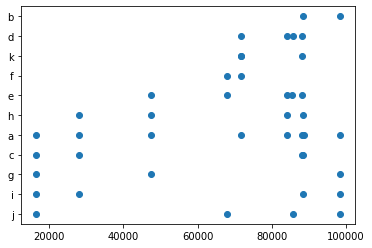

In [12]:
# convert to pandas Dataframe for easy plotting
df = pd.read_table('./output_conjunction_nsym3_n1000.txt', names=['time', 'symbol'], sep=',')

values = df['symbol'].to_list()
names = df['time'].to_list()

plt.scatter(names, values);

## TODO: 
- Generate .pred file
- Negation? not 100% on how to implement this.
- Different types of Noise?